# Соревнование по кредитному скорингу

Данный проект посвящён решению задачи кредитного скоринга — прогнозированию вероятности невозврата займа клиентом банка на основе исторических данных. Цель работы — разработать и обучить модель машинного обучения, которая по совокупности признаков сможет оценить риск дефолта и тем самым помочь банку принимать более обоснованные решения о выдаче кредитов.

В распоряжении — датасет с более чем миллионом записей и сотней признаков, содержащих информацию о параметрах займа,  финансовых показателях и кредитной истории. Задача формулируется как бинарная классификация:

* 0 — займ выплачен,

* 1 — займ не выплачен.

Для успешного решения задачи особое внимание уделено:

* исследовательскому анализу данных (EDA) и выявлению закономерностей;

* обработке пропусков, аномалий и подготовке признаков;

* построению и сравнению нескольких моделей с последующим выбором оптимальной;

* подбору гиперпараметров с кросс-валидацией для повышения качества;

* интерпретации результатов с использованием методов анализа важности признаков (SHAP).

В результате будет получена финальная модель, формирующая прогноз в формате, соответствующем требованиям конкурса, с расчётом вероятности невозврата по каждому клиенту тестового набора.

## Оглавление
- [1. Импорты и конфигурация](#1-импорты-и-конфигурация)
- [2. Загрузка данных](#2-загрузка-данных)
- [3. Первичный осмотр данных](#3-первичный-осмотр-данных)
- [4. EDA (Исследовательский анализ данных)](#4-eda-исследовательский-анализ-данных)
  - [4.1. Анализ целевой переменной](#41-анализ-целевой-переменной)
  - [4.2. Анализ корреляции признаков с целевой переменной](#42-анализ-корреляции-признаков-с-целевой-переменной)
  - [4.3. Визуализация зависимости целевой переменной от признаков](#43-визуализация-зависимости-целевой-переменной-от-признаков)
  - [4.4. Анализ пропусков данных](#44-анализ-пропусков-данных)
- [5. Обработка данных](#5-обработка-данных)
- [6. Создание новых признаков. Масштабирование и превращение категориальных переменных в непрервные](#6-создание-новых-признаков-масштабирование-и-превращение-категориальных-переменных-в-непрервные)
- [7. Обучение и сравнение простых моделей Логистической регрессии и Случайного леса](#7-обучение-и-сравнение-простых-моделей-логистической-регрессии-и-случайного-леса)
- [8. Обучение и сравнение бустинговых моделей](#8-обучение-и-сравнение-бустинговых-моделей)
- [9. Подбор гиперпараметров финальной модели CatBoost](#9-подбор-гиперпараметров-финальной-модели-catboost)
- [10. Интерпретация модели с помощью библиотеки SHAP](#10-интерпретация-модели-с-помощью-библиотеки-shap)
  - [10.1. Глобальная значимость признаков](#101-глобальная-значимость-признаков)
  - [10.2. Значимость признаков для отдельных клиентов](#102-значимость-признаков-для-отдельных-клиентов)
- [11. Проверка утечки данных через признаки](#11-проверка-утечки-данных-через-признаки)
- [12. Предсказания и сохранение submission](#12-предсказания-и-сохранение-submission)
- [Итог](#итог)

<!-- TOC -->
<!-- /TOC -->

## 1. Импорты и конфигурация

In [44]:
import pandas as pd
import numpy as np, random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import missingno as msno
import shap
import os
import warnings

warnings.filterwarnings('ignore')

## 2. Загрузка данных

In [45]:
# Замените пути к данным на актуальные
train_path = 'shift_ml_2025_train.csv'
test_path = 'shift_ml_2025_test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

## 3. Первичный осмотр данных

In [46]:
train.head()

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,...,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,68355089,1235000.0,3 года,11.99,41014.0,В,В1,инженер,10+ лет,ИПОТЕКА,...,7.7,0.0,0.0,15700850.0,1973750.0,3965000.0,1233350.0,NaN,Нет,Наличные
1,68341763,1000000.0,5 лет,10.78,21633.0,Б,Б4,водитель грузовика,10+ лет,ИПОТЕКА,...,50.0,0.0,0.0,10920900.0,934800.0,310000.0,743850.0,NaN,Нет,Наличные
2,68426831,597500.0,3 года,13.44,20259.0,В,В3,ветеринарный техник,4 года,АРЕНДА,...,100.0,0.0,0.0,845000.0,639900.0,470000.0,200000.0,NaN,Нет,Наличные
3,68476668,1000000.0,3 года,9.17,31879.0,Б,Б2,вице-президент операций по набору персонала,10+ лет,ИПОТЕКА,...,100.0,0.0,0.0,19442600.0,5838100.0,1575000.0,2322600.0,NaN,Нет,Наличные
4,67275481,1000000.0,3 года,8.49,31563.0,Б,Б1,дорожному водителю,10+ лет,ИПОТЕКА,...,0.0,0.0,0.0,9669500.0,1396850.0,725000.0,1807200.0,NaN,Нет,Наличные


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 109 entries, id to тип_предоставления_кредита
dtypes: float64(84), int64(6), object(19)
memory usage: 1006.9+ MB


In [48]:
# Изучение непрерывных переменных тренировочных данных
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,1210779.0,5.634301e+07,3.836485e+07,55716.00,20007112.00,57734178.00,84546640.50,1.456364e+08
сумма_займа,1210779.0,7.210352e+05,4.358215e+05,25000.00,400000.00,600000.00,1000000.00,2.000000e+06
процентная_ставка,1210779.0,1.323988e+01,4.767252e+00,5.31,9.75,12.74,15.99,3.099000e+01
аннуитет,1210779.0,2.190478e+04,1.307606e+04,246.50,12424.00,18771.50,29022.00,8.599150e+04
годовой_доход,1210779.0,1.525304e+06,1.401176e+06,0.00,915200.00,1300000.00,1800000.00,2.199840e+08
...,...,...,...,...,...,...,...,...
кредитный_лимит,1150012.0,8.723506e+06,8.908827e+06,0.00,2482050.00,5623025.00,12604450.00,5.000000e+08
кредитный_баланс_без_ипотеки,1168297.0,2.483355e+06,2.387537e+06,0.00,1044150.00,1865200.00,3127100.00,1.704048e+08
лимит_по_картам,1168297.0,1.082325e+06,1.078610e+06,0.00,390000.00,755000.00,1405000.00,5.527500e+07
лимит_по_аннуитетным_счетам,1150012.0,2.106562e+06,2.164373e+06,0.00,736550.00,1583950.00,2831450.00,1.050956e+08


In [49]:
# Изучение непрерывных переменных тестовых данных
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,134531.0,5.636289e+07,3.832781e+07,54734.00,20087415.50,57753933.00,84526810.50,1.456270e+08
сумма_займа,134531.0,7.206690e+05,4.361330e+05,37500.00,397500.00,600000.00,1000000.00,2.000000e+06
процентная_ставка,134531.0,1.323729e+01,4.781888e+00,5.31,9.75,12.74,15.99,3.099000e+01
аннуитет,134531.0,2.189475e+04,1.307184e+04,1099.50,12415.00,18753.00,29112.75,8.572700e+04
годовой_доход,134531.0,1.521789e+06,1.374204e+06,0.00,920000.00,1300000.00,1800000.00,1.800000e+08
...,...,...,...,...,...,...,...,...
кредитный_лимит,127771.0,8.682367e+06,8.868457e+06,0.00,2471175.00,5580000.00,12597200.00,5.000000e+08
кредитный_баланс_без_ипотеки,129732.0,2.482979e+06,2.383985e+06,0.00,1046137.50,1861575.00,3130825.00,1.460776e+08
лимит_по_картам,129732.0,1.076076e+06,1.069851e+06,0.00,385000.00,750000.00,1400000.00,2.354500e+07
лимит_по_аннуитетным_счетам,127771.0,2.107542e+06,2.146652e+06,0.00,739600.00,1584900.00,2835350.00,5.711145e+07


In [50]:
# Изучение категориальных переменных тренировочных данных
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    print(f'{col}: {train[col].nunique()} кол-во значений: {100 * train[col].isna().sum()/len(train)}% пропущенных значений')

срок_займа: 2 кол-во значений: 0.0% пропущенных значений
рейтинг: 7 кол-во значений: 0.0% пропущенных значений
допрейтинг: 35 кол-во значений: 0.0% пропущенных значений
профессия_заемщика: 273666 кол-во значений: 6.363589061257256% пропущенных значений
стаж: 11 кол-во значений: 5.82335835028523% пропущенных значений
владение_жильем: 6 кол-во значений: 0.0% пропущенных значений
подтвержден_ли_доход: 3 кол-во значений: 0.0% пропущенных значений
платежный_график: 1 кол-во значений: 0.0% пропущенных значений
цель_займа: 14 кол-во значений: 0.0% пропущенных значений
регион: 51 кол-во значений: 0.0% пропущенных значений
пос_стоп_фактор: 3 кол-во значений: 0.0% пропущенных значений
юридический_статус: 2 кол-во значений: 0.0% пропущенных значений
дата_первого_займа: 738 кол-во значений: 0.0% пропущенных значений
первоначальный_статус_займа: 2 кол-во значений: 0.0% пропущенных значений
пени_за_дефолт: 2 кол-во значений: 30.01712120874247% пропущенных значений
тип_займа: 2 кол-во значений: 0.0% 

In [51]:
# Изучение категориальных переменных тестовых данных
cat_cols = test.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    print(f'{col}: {test[col].nunique()} кол-во значений: {100 * test[col].isna().sum()/len(train)}% пропущенных значений')

срок_займа: 2 кол-во значений: 0.0% пропущенных значений
рейтинг: 7 кол-во значений: 0.0% пропущенных значений
допрейтинг: 35 кол-во значений: 0.0% пропущенных значений
профессия_заемщика: 46727 кол-во значений: 0.7215189559779283% пропущенных значений
стаж: 11 кол-во значений: 0.6609794190351831% пропущенных значений
владение_жильем: 6 кол-во значений: 0.0% пропущенных значений
подтвержден_ли_доход: 3 кол-во значений: 0.0% пропущенных значений
платежный_график: 1 кол-во значений: 0.0% пропущенных значений
цель_займа: 14 кол-во значений: 0.0% пропущенных значений
регион: 50 кол-во значений: 0.0% пропущенных значений
пос_стоп_фактор: 3 кол-во значений: 0.0% пропущенных значений
юридический_статус: 2 кол-во значений: 0.0% пропущенных значений
дата_первого_займа: 663 кол-во значений: 0.0% пропущенных значений
первоначальный_статус_займа: 2 кол-во значений: 0.0% пропущенных значений
тип_займа: 2 кол-во значений: 0.0% пропущенных значений
совокупный_статус_подтверждения_доходов_заемщиков: 3

**Основные выводы при первичном осмотре данных:**
1) id - уникальный идентификатор клиента, можно опутстить в рабоет с тренировочными данными, обращаясь к клиентам по номеру строки

2) Одинаковое значение для всех клиентов признаков: коэфф_невыплаченного_сумм_остатка -	1345311.538
                                                    непогашенная_сумма_из_тела_займов - все значения равны 0  
                                                    дата_следующей_выплаты - нет значений  
                                                    код_политики - у всех равен 1  

3) рейтинг_OCR - категориальная переменная (значения только 1, 2, 3, 4)  
  
4) Наблюдаются выбросы признаков: пдн - есть знаения -1 и 999 (скорее всего для этих людей значение неизвестно)  
                                  кол-во_месяцев_с_первого_аннуитетного_счета - есть значение 999 (~83 года, как-будто закодировано неизвестно значение)

5) В данных наблюдаются следующие признаки с явно смещенным распределением или выбросами: годовой_доход, оборотный_баланс, сумма_выплат_по_просрочкам, совокупный_доход_заемщиков, общая_сумма_взысканий, общая_сумма_на_счетах, макс_баланс_по_возоб_счетам, общий_лимит_по_возоб_счету, средний_баланс_текущих_счетов, суммарная_доступная_сумма_займа_по_картам, сумма_задолженности, кол-во_месяцев_с_последнего_возобновляемого_счета, кол-во_месяцев_с_последнего_счета, кол-во_месяцев_с_последней_карты, кол-во_счетов_с_просрочкой_4_мес, кредитный_лимит, кредитный_баланс_без_ипотеки, лимит_по_картам, лимит_по_аннуитетным_счетам

6) Большое количество различных значений в колонке профессии (скорее всего из-за ошибок написания названия профессии, а также выдуманных позиций). Редкие профессии будут объединены в отдельную группу "Остальные" в разделе работы с данными.  
   Большое количество различных значений в колонке дата_первого_займа. Извлечем из нее полезную информацию пересчитав её в стаж кредитования в разделе работы с данными

7) Есть признаки, которые могут приводить к утечке данных: сумма_выплат_по_просрочкам, пени_за_дефолт, общая_сумма_взысканий, кол-во_месяцев_с_последнего_нарушения. Посмотрим на эти колоноки, когда определим важность признаков на предсказание модели.

## 4. EDA (Исследовательский анализ данных)

### 4.1 Анализ целевой переменной

итоговый_статус_займа
0    0.800381
1    0.199619
Name: count, dtype: float64

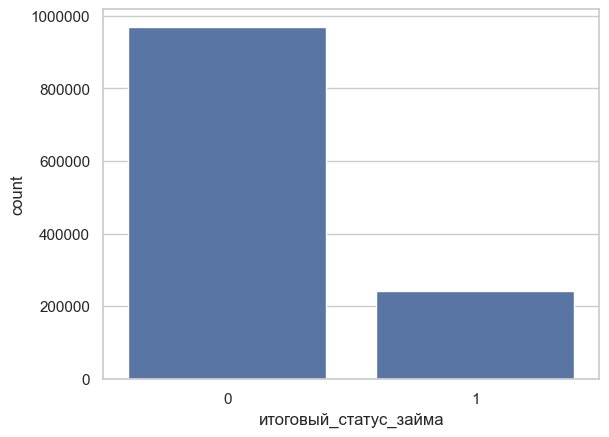

In [52]:
# Распределение целевой переменной
plt.figure(dpi=100)
sns.countplot(data=train, x='итоговый_статус_займа')
plt.ticklabel_format(axis='y', style='plain');

train['итоговый_статус_займа'].value_counts() / len(train)

**Вывод:** в данных присутствует **дисбаланс**, 969 085 вернули займ (80%) и 241 694 (20%) не вернули

### 4.2 Анализ корреляции признаков с целевой переменной 

Посмотрим топ признаков коррелирующих с целевой переменной:

In [53]:
# Создадим матрицу корреляции для непрерывных признаков
corr_matrix = train.select_dtypes(include=['int64', 'float64']).corr()

# Выбираем только корреляции с целевой переменной
target_corr = corr_matrix[['итоговый_статус_займа']].sort_values(by='итоговый_статус_займа', ascending=False)
print(target_corr.head(10), target_corr.tail(10), sep='\n')

                                       итоговый_статус_займа
итоговый_статус_займа                               1.000000
процентная_ставка                                   0.258279
совокупный_пдн_заемщиков                            0.140543
сумма_выплат_по_просрочкам                          0.140362
кол-во_открытых_счетов_за_2_года                    0.100366
соотношение_баланса_к_лимиту_общее                  0.088790
кол-во_счетов_за_посл_год                           0.086119
пдн                                                 0.084023
кол-во_возоб_счетов_за_2_года                       0.082508
кол-во_активных_возобновляемых_счетов               0.071040
                                           итоговый_статус_займа
кредитный_лимит                                        -0.078076
средний_баланс_текущих_счетов                          -0.078647
суммарная_доступная_сумма_займа_по_картам              -0.081696
совокупный_доход_заемщиков                             -0.090133
верх

**Наибольшую корреляцию с целевой переменной имеют колонки:**
1) процентная_ставка и сумма_выплат_по_просрочкам, которые должны отражать риск невозврата кредита
2) совокупный_пдн_заемщика и совокупный_доход_заемщиков - видимо дает большой вклад, однако только для тех клиентов у кого он указан (их меньше 2% от общего числа)
3) верхний и нижний пороги рейтинга заемщика, которые отражают допустимые границы кредитного рейтинга.

### 4.3 Визуализация зависимости целевой переменной от признаков

Для интерпретации и визуализации зависимости целевой переменной от различных признаков, я выбрал 6 из них, которые с точки зрения кредитного анализа имеют прямое влияние на риск невыполнения обязательств:

- **Аннуитет** — регулярный платёж по кредиту. Используется для оценки кредитной нагрузки клиента.
- **Процентная ставка** — показатель, отражающий оценку риска со стороны банка. Высокие ставки часто назначаются менее надёжным клиентам.
- **ПДН (платежная нагрузка)** — один из главных банковских коэффициентов: сколько процентов от дохода уходит на выплаты. Чем выше ПДН, тем выше риск.
- **Годовой доход** — классический фактор платёжеспособности клиента.
- **Рейтинг и подрейтинг** — внутренние или внешние категориальные оценки надёжности, часто являются результатом скоринговой модели и полезны как входные признаки для новой модели.

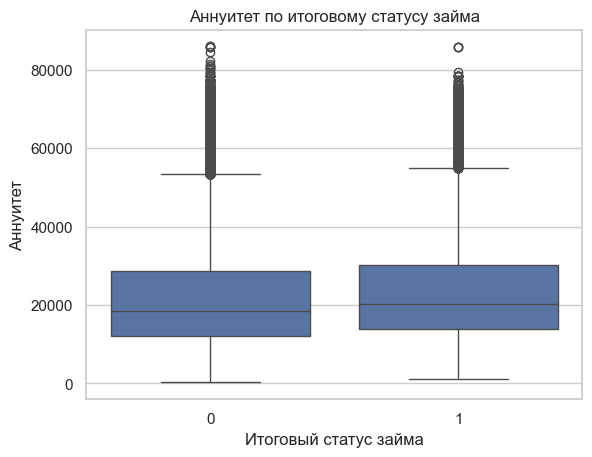

In [54]:
sns.set(style='whitegrid')

sns.boxplot(x='итоговый_статус_займа', y='аннуитет', data=train)
plt.title('Аннуитет по итоговому статусу займа')
plt.xlabel('Итоговый статус займа')
plt.ylabel('Аннуитет')
plt.show()

**Аннуитет**  
Видно слабое, но заметное различие между группами. В среднем человек допускающий дефолт, имеет больший платеж по займу.

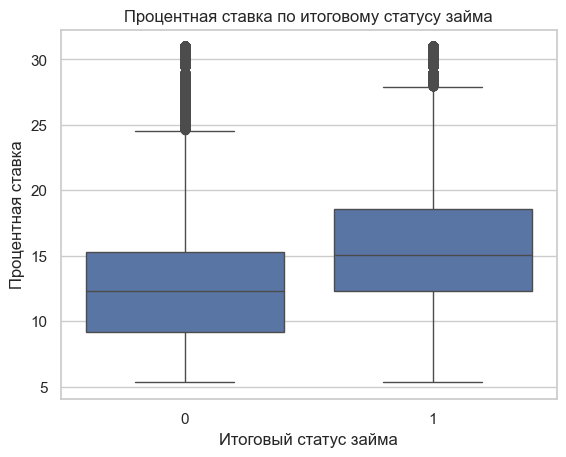

In [55]:
sns.boxplot(x='итоговый_статус_займа', y='процентная_ставка', data=train)
plt.title('Процентная ставка по итоговому статусу займа')
plt.xlabel('Итоговый статус займа')
plt.ylabel('Процентная ставка')
plt.show()

**Процентная ставка**  
Можно предположить, что банк назначает тем выше процентную ставку, чем выше возможность того, что клиент не вернет займ.

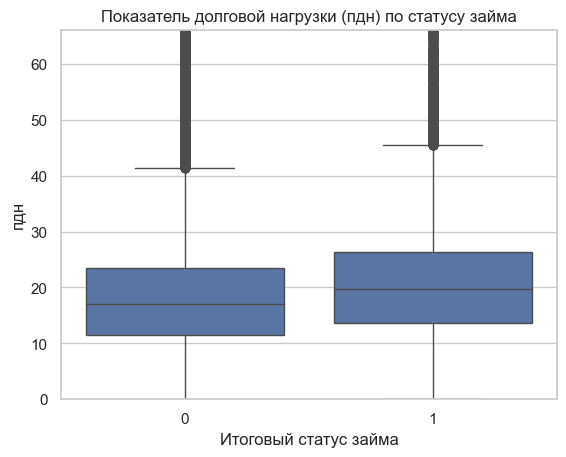

In [56]:
# Ограничим ось У, чтобы боксы не сжимались
q_high = train['пдн'].quantile(0.999)

sns.boxplot(x='итоговый_статус_займа', y='пдн', data=train)
plt.title('Показатель долговой нагрузки (пдн) по статусу займа')
plt.xlabel('Итоговый статус займа')
plt.ylabel('пдн')
plt.ylim(0, q_high)
plt.show()

**ПДН**  
Можно заключить, что заемщики со средним **ПДН выше** чаще допускают **невозврат** займа, поскольку повышенная долговая нагрузка означает, что значительная часть их дохода уже уходит на обслуживание существующих обязательств.

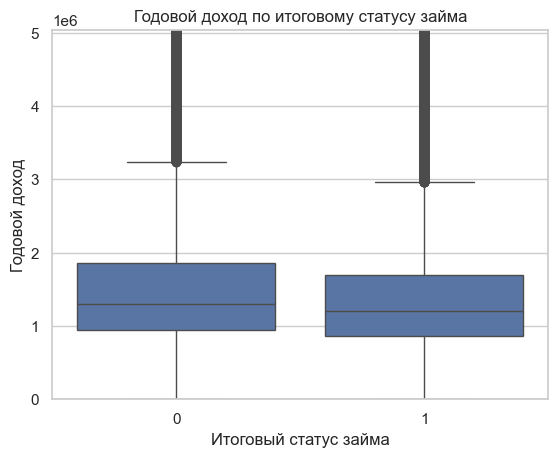

In [57]:
q_high = train['годовой_доход'].quantile(0.99)

sns.boxplot(x='итоговый_статус_займа', y='годовой_доход', data=train)
plt.title('Годовой доход по итоговому статусу займа')
plt.xlabel('Итоговый статус займа')
plt.ylabel('Годовой доход')
plt.ylim(0, q_high)
plt.show()

**Годовой доход**  
Также можно отметить, что чем выше годовой доход заемщика, тем выше вероятность возврата займов, поскольку у таких клиентов больше финансовых ресурсов для своевременного погашения обязательств.

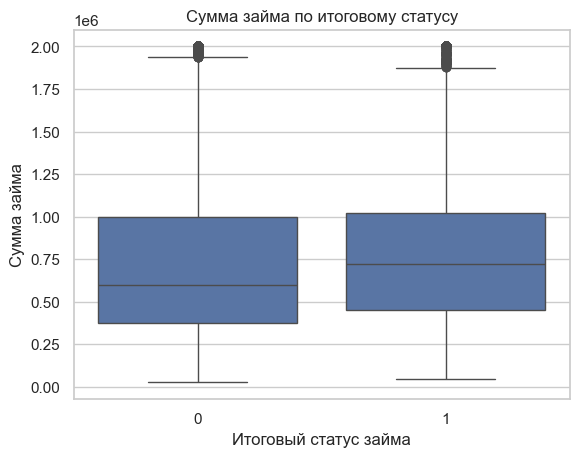

In [58]:
sns.boxplot(x='итоговый_статус_займа', y='сумма_займа', data=train)
plt.title('Сумма займа по итоговому статусу')
plt.xlabel('Итоговый статус займа')
plt.ylabel('Сумма займа')
plt.show()

**Сумма займа**  
Хотя максимальная сумма займа практически не отличается, среднее значение для этого признака явно больше у людей не вернувших займ. Соответственно можно сделать предположение, что чем больше сумма займа, тем с меньшей вероятности он будет возвращен.

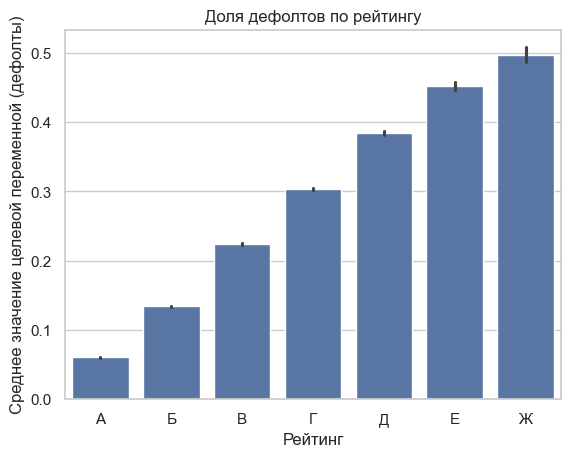

In [59]:
sns.barplot(x='рейтинг', y='итоговый_статус_займа', data=train, order=['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж'])
plt.title('Доля дефолтов по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Среднее значение целевой переменной (дефолты)')
plt.show()

**Рейтинг**  
Отчетливо прослеживается зависимость доли дефолтов от значения внутреннего рейтинга: рейтинг, рассчитанный по установленным правилам, достаточно точно отражает вероятность невозврата займа.

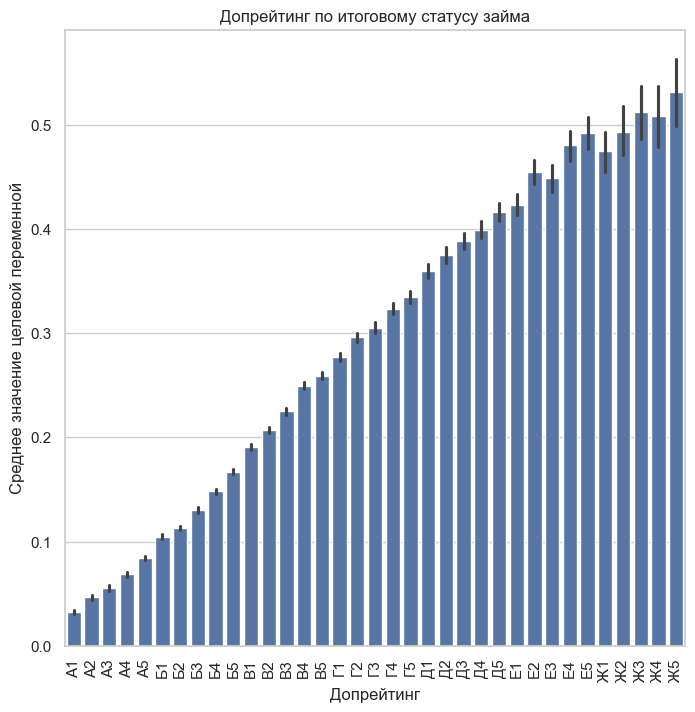

In [60]:
plt.figure(figsize=(8,8))
sns.barplot(y='итоговый_статус_займа', x='допрейтинг', data=train, order=sorted(train['допрейтинг'].unique()))
plt.title('Допрейтинг по итоговому статусу займа')
plt.xlabel('Допрейтинг')
plt.ylabel('Среднее значение целевой переменной')
plt.xticks(rotation=90)
plt.show()

**Допрейтинг**  
Допрейтинг разбивает группы клиентов из рейтинга, что позволяет точнее определять вероятность дефолта, а также решать пограничные случаи на границе двух категорий рейтинга, что наиболее заметно для границы рейтинга Е - Ж.

### 4.4 Анализ пропусков данных

Далее перейдем к анализу пропусков в наших данных. Для начала отоброзим их на общем графике, а в последствии выделим из них колонки с наибольшим количеством пропусков.

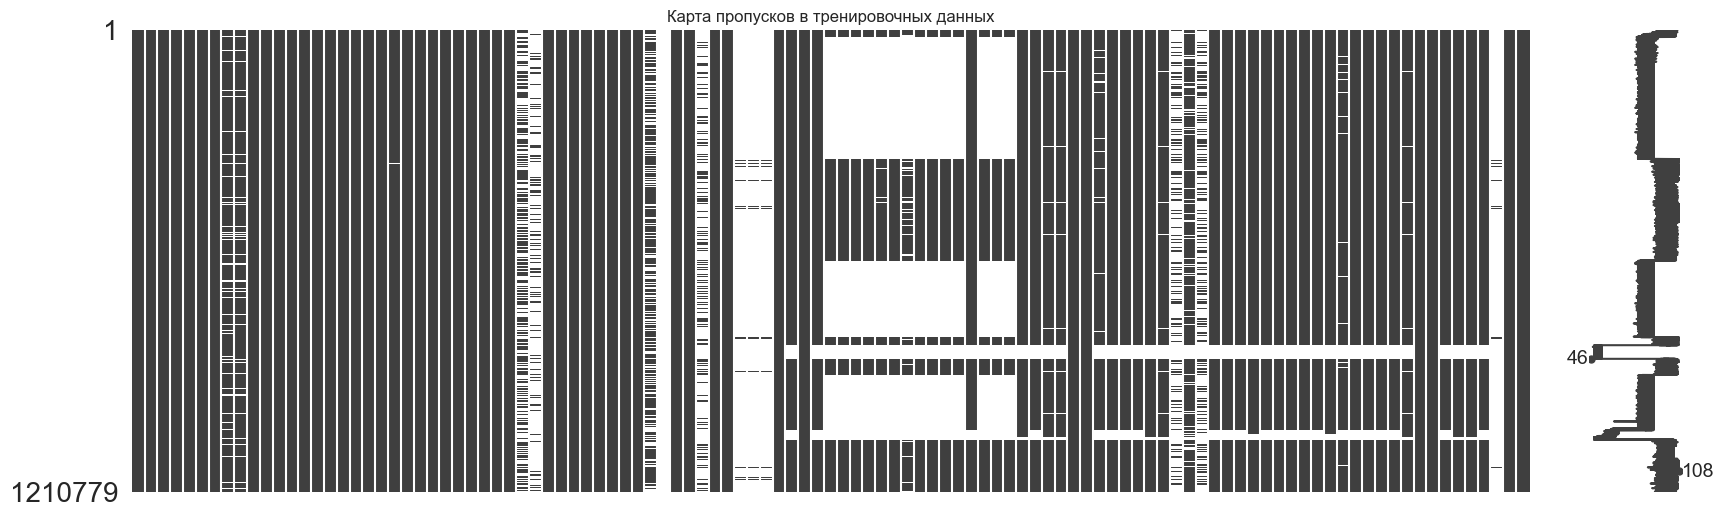

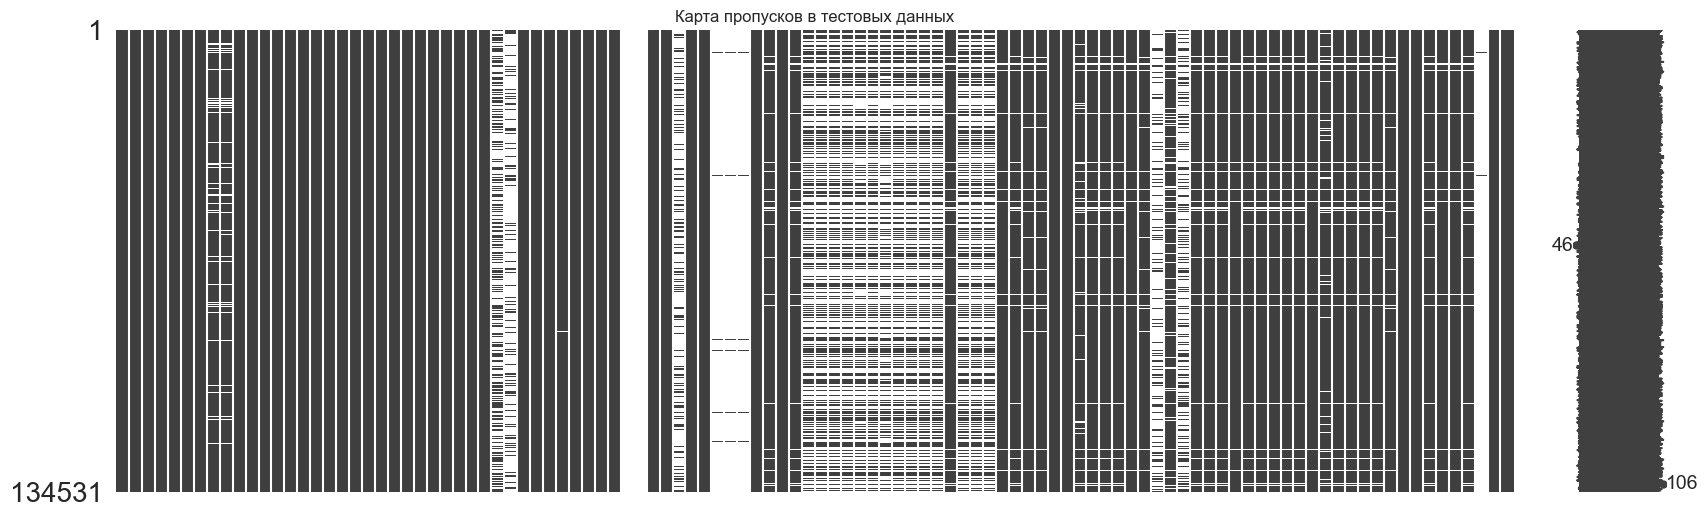

In [61]:
# Построение карт пропусков
msno.matrix(train, figsize=(20, 6))
plt.title('Карта пропусков в тренировочных данных')
plt.show()

msno.matrix(test, figsize=(20, 6))
plt.title('Карта пропусков в тестовых данных')
plt.show()

In [62]:
# Определим функцию для подсчета количества колонок в df с процентом пропущенных значений больше n
def percent_missing(my_df, n):
    '''
    Функция для подсчета количества колонок с процентом пропущенных данных
    параметр df исследуемый датафрейм 
    параметр n граниченое значения процента пропусков
    возвращает название колонок и процент пропусков в виде pd.Series
    '''
    result = 100 * my_df.isna().sum() / len(my_df)
    result = result[result>n].sort_values()
    return result

кол-во_месяцев_с_последней_просрочки                                 50.427122
кол-во_аннуитетных_счетов_за_2_года                                  60.035812
кол-во_возоб_счетов_за_год                                           60.035812
кол-во_возоб_счетов_за_2_года                                        60.035812
текущий_баланс_по_аннуитетным_счетам                                 60.035812
кол-во_текущих_аннуитетных_счетов                                    60.035812
кол-во_аннуитетных_счетов_за_год                                     60.035812
макс_баланс_по_возоб_счетам                                          60.035812
кол-во_финансовых_запросов                                           60.035812
кол-во_финансовых_операций                                           60.035894
кол-во_заявок_на_кредит_за_год                                       60.035894
кол-во_открытых_счетов_за_полгода                                    60.035894
соотношение_баланса_к_лимиту_общее                  

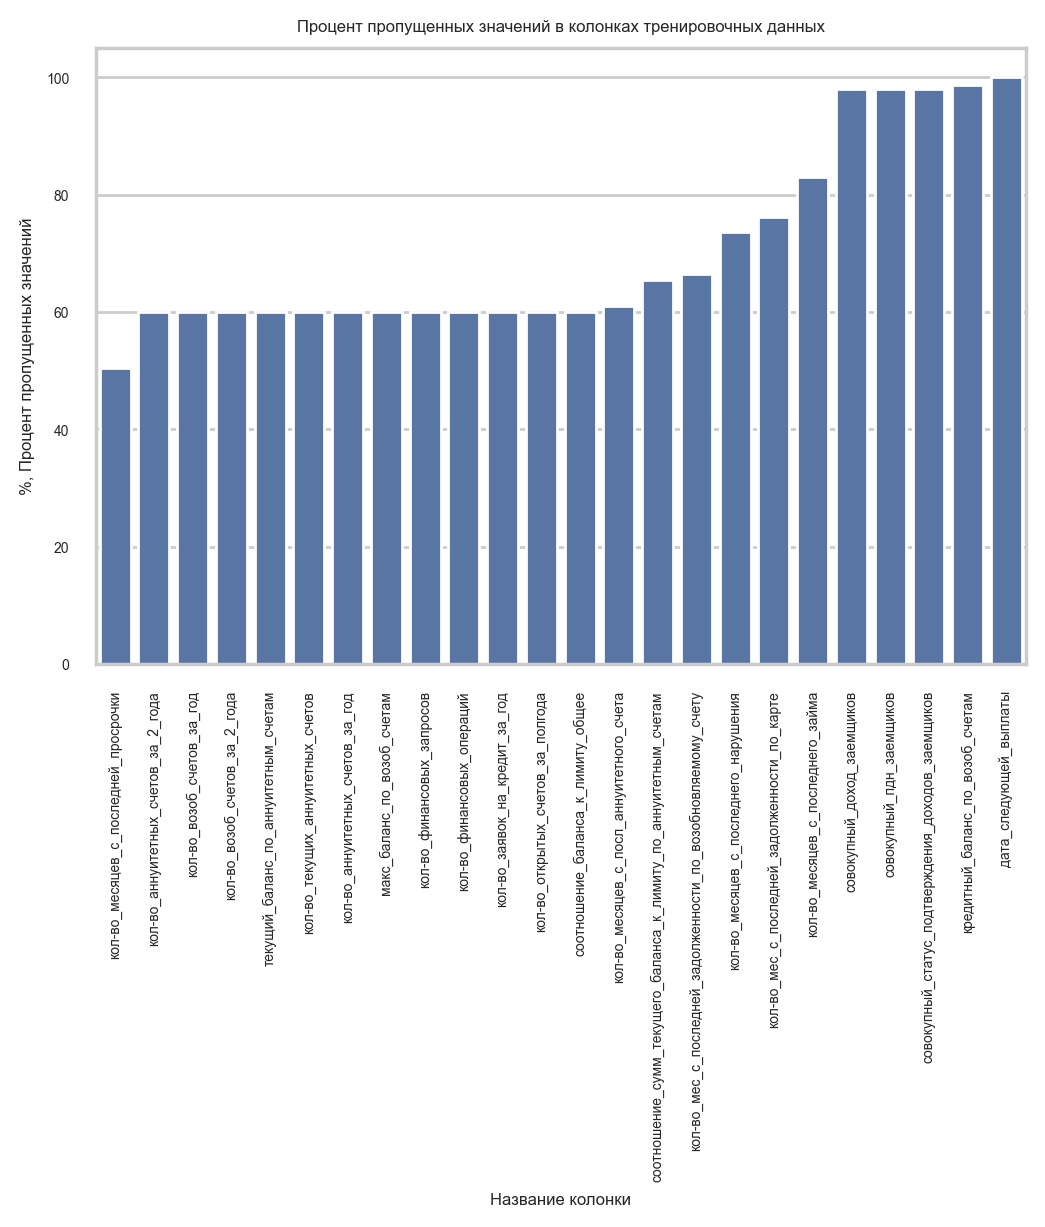

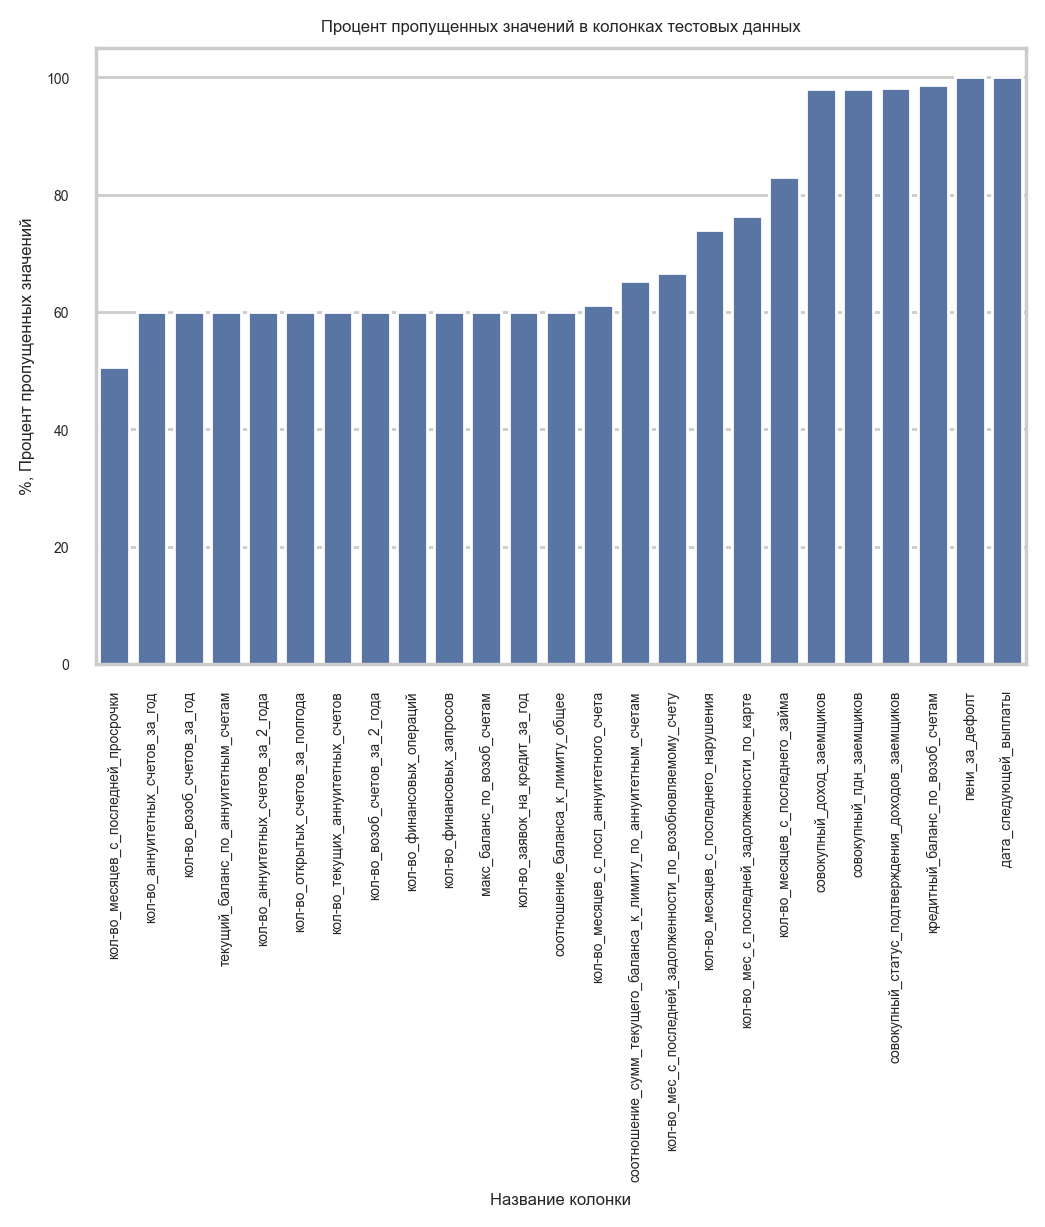

In [63]:

# Посмотрим, какие колонки имеют кол-во пропусков больше 50% в тренировочных данных
percent_nan = percent_missing(train,50)
# Построим график
plt.figure(figsize=(6,4), dpi=200)
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90)
plt.xlabel('Название колонки', fontsize=6)
plt.xticks(fontsize=5)
plt.ylabel('%, Процент пропущенных значений', fontsize=6)
plt.yticks(fontsize=5)
plt.locator_params(axis='y', nbins=8)
plt.title('Процент пропущенных значений в колонках тренировочных данных', fontsize=6);

# Тоже самое посмотрим на тестовых данных
percent_nan_test = percent_missing(test, 50)
plt.figure(figsize=(6,4), dpi=200)
sns.barplot(x=percent_nan_test.index, y=percent_nan_test)
plt.xticks(rotation=90)
plt.xlabel('Название колонки', fontsize=6)
plt.xticks(fontsize=5)
plt.ylabel('%, Процент пропущенных значений', fontsize=6)
plt.yticks(fontsize=5)
plt.locator_params(axis='y', nbins=8)
plt.title('Процент пропущенных значений в колонках тестовых данных', fontsize=6);

print(percent_nan)
print(percent_nan_test)

**Выводы по признакам с пропусками данных более 50% в тренировочных данных:**
1) К кандидатом на удаление стоит отнести колонку дата_следующей_выплаты в которой нет никаких значений. 98% пустых значений также в колонке кредитный_баланс_по_возоб_счетам. Данные признаки не связаны с другими и могут быть удалены.  
2) Можно выделить группу колонок относящихся к "совокупному" займу, имеющиму маленький процент от общего числа займа. Такие колонки лучше всего будет выделить в отдельную группу, например пометить флагом, чтобы модель выделяла их в качестве отдельного случая, а все недостающие значения заполнить нулями.  
3) Группа колонок относящихся к отсутствующей информации по таким продуктам как: аннуитетные счета, возобновляемые счета, карты. Моя гипотеза заключается в отсутствии данных у банка по этим признакам у новых клиентов и клиентов отсутствующих в общей базе. Поэтому следует объединить эти колонки между собой и также обработать с помощью добавления флага, а недостоющие значения также заполнить 0.  
4) Отдельно выделяется три колонки указывающие на нарушения - кол-во_мес_с_последней_задолженности_по_возобновляемому_счету, кол-во_месяцев_с_последнего_нарушения (отнесем к аннуитетным счета), кол-во_мес_с_последней_задолженности_по_карте. Процент отсутствующих данных в них немного больше, чем в 3 пункте, скорее всего потому что у части клиентов нарушений не было. Отнесем эти колонки к группам соответствующего продукта.  
5) кол-во_месяцев_с_последнего_займа - с пропусками 83% данных заполним 0, считая что для остальных неизвестно.  
6) кол-во_месяцев_с_последней_просрочки  - с пропуска 50%, заполним 0, считая что у остальных не было просрочек.
7) Значения с пропусками меньше чем 50% обработаем отдельно по похожей схеме. Со систематичными пропусками будем работать с помощью флагов. Не систематичные попробуем заполнить медианными/средними/модой по всем данным/сгруппированным данным.

In [64]:
# Анализ признаков с пропусками от 0 до 50% в тренировочных данных
percent_nan_0 = percent_missing(train, 0)
percent_nan_0[percent_nan_0 < 50]

индекс_проживания                                     0.000083
кол-во_заявок_за_полгода                              0.000083
кол-во_залогов                                        0.002808
кол-во_взысканий_за_последний_год                     0.003882
кол-во_списаний_за_год                                0.003882
пдн                                                   0.027916
кол-во_публ_банкротств                                0.051042
коэфф_загрузки_возобновляемого_счета                  0.063513
кол-во_открытых_счетов_за_2_года                      3.508650
кол-во_ипотек                                         3.508650
лимит_по_картам                                       3.508650
кредитный_баланс_без_ипотеки                          3.508650
кол-во_карт_без_нарушений                             4.146669
кол-во_счетов_без_нарушений                           4.146669
кол-во_месяцев_с_последней_карты                      4.470675
суммарная_доступная_сумма_займа_по_картам             4

**Выводы по признакам с пропусками данных от 0 до 50% в тренировочных данных:**
1) Группа пропусков 3-5% связана с основными группами продуктов: аннуитетные счета, возобновляемые счета, карты, ипотека, счет. Которые можно выделить в отдельную категорию клиентов и колонок, помеченных флагом, и заполненными 0 для отсутствующих данных.  
2) Колонку пени_за_дефолт не будем заполнять, так как эта колонка будет приводить к утечке данных и в тестовых данных эта колонка пустая.  
3) Оставшиеся пустые колонки заполним медианой или модой в зависимости от типа данных признака.

## 5. Обработка данных

1) Удаляем колонки с большим количеством пропусков или имеющих одинаковое значение для всех клиентов: 'коэфф_невыплаченного_сумм_остатка', 'непогашенная_сумма_из_тела_займов', 'код_политики', 'дата_следующей_выплаты', 'кредитный_баланс_по_возоб_счетам'
2) Корректируем выбросы в колонках 'пдн' и 'кол-во_месяцев_с_последнего_займа'
3) Перевод колонки 'рейтинг_OCR' в категориальный формат
5) Заполним оставшиеся пропуски по алгоритму описанному в пункте 4.4
6) Объединим редкие профессии в одну группу
7) Логарифмируем признаки со смещенным распределением.

In [65]:
# Удаление колонок
train = train.drop(['коэфф_невыплаченного_сумм_остатка', 
                    'непогашенная_сумма_из_тела_займов', 
                    'код_политики', 'дата_следующей_выплаты', 
                    'кредитный_баланс_по_возоб_счетам', 'пени_за_дефолт', 'id'], axis=1)
# Обработка значений пдн и кол-во_месяцев_с_последнего_займа
train['пдн'] = train['пдн'].replace([-1, 999], np.nan)
train['кол-во_месяцев_с_последнего_займа'] = train['кол-во_месяцев_с_последнего_займа'].replace(999, np.nan)

# Переводим рейтинг_OCR в категориальные переменные
train['рейтинг_OCR'] = train['рейтинг_OCR'].astype(str)

# Заполнение пропусков 'совокупный'
train_filled = train.copy()
group_cols_98 = ['совокупный_доход_заемщиков',
    'совокупный_пдн_заемщиков',
    'совокупный_статус_подтверждения_доходов_заемщиков']
# Флаг наличия данных по группе
train_filled['совокупный'] = train_filled[group_cols_98].notna().any(axis=1).astype(int)
# Заполнение
train_filled[group_cols_98] = train_filled[group_cols_98].fillna(0)
train_filled['совокупный_статус_подтверждения_доходов_заемщиков'] = train_filled['совокупный_статус_подтверждения_доходов_заемщиков'].fillna('Unknown')

# Аналогично для группы с пропусками от 60 до 90%
group_cols_60 = ['кол-во_аннуитетных_счетов_за_2_года', 'кол-во_возоб_счетов_за_год',
       'кол-во_возоб_счетов_за_2_года', 'текущий_баланс_по_аннуитетным_счетам',
       'кол-во_текущих_аннуитетных_счетов', 'кол-во_аннуитетных_счетов_за_год',
       'макс_баланс_по_возоб_счетам', 'кол-во_финансовых_запросов',
       'кол-во_финансовых_операций', 'кол-во_заявок_на_кредит_за_год',
       'кол-во_открытых_счетов_за_полгода',
       'соотношение_баланса_к_лимиту_общее',
       'кол-во_месяцев_с_посл_аннуитетного_счета',
       'соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам',
       'кол-во_мес_с_последней_задолженности_по_возобновляемому_счету',
       'кол-во_месяцев_с_последнего_нарушения',
       'кол-во_мес_с_последней_задолженности_по_карте',
       'кол-во_месяцев_с_последнего_займа']

train_filled['has_annuity_related_data'] = train_filled[group_cols_60].notna().any(axis=1).astype(int)
train_filled[group_cols_60] = train_filled[group_cols_60].fillna(0)

# Аналогично для группы с пропусками от 3 до 10%
group_cols_5 = ['кол-во_открытых_счетов_за_2_года', 'кол-во_ипотек', 'лимит_по_картам',
       'кредитный_баланс_без_ипотеки', 'кол-во_карт_без_нарушений',
       'кол-во_счетов_без_нарушений', 'кол-во_месяцев_с_последней_карты',
       'суммарная_доступная_сумма_займа_по_картам',
       'процент_счетов_прев_75_лимита',
       'соотношение_баланса_к_лимиту_по_картам',
       'кол-во_месяцев_с_последнего_счета', 'кол-во_активных_карт',
       'кол-во_аннуитетных_счетов', 'общая_сумма_взысканий', 'кол-во_карт',
       'кол-во_счетов_с_просрочкой_4_мес',
       'кол-во_счетов_с_акт_просрочкой_1_мес',
       'кол-во_открытых_возобновляемых_счетов',
       'кол-во_активных_возобновляемых_счетов', 'кол-во_счетов_за_посл_год',
       'кол-во_возобновляемых_счетов_с_балансом_более_0',
       'кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года',
       'общий_лимит_по_возоб_счету', 'общая_сумма_на_счетах',
       'лимит_по_аннуитетным_счетам', 'кредитный_лимит',
       'кол-во_месяцев_с_первого_возобновляемого_счета',
       'кол-во_месяцев_с_последнего_возобновляемого_счета',
       'кол-во_возобновляемых_счетов', 'средний_баланс_текущих_счетов',
       'процент_счетов_без_просрочек',
       'кол-во_месяцев_с_первого_аннуитетного_счета',
       'кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес']

train_filled['has_active_accounts_data'] = train_filled[group_cols_5].notna().any(axis=1).astype(int)
train_filled[group_cols_5] = train_filled[group_cols_5].fillna(0)

# Оставшиеся колонки заполним медианой или наиболее популярным значением
for col in percent_missing(train_filled, 0).index.tolist():
    if train_filled[col].dtype in ['int64', 'float64']:
        train_filled[col] = train_filled[col].fillna(train_filled[col].median())
    else:
        train_filled[col] = train_filled[col].fillna(train_filled[col].mode()[0])

# Объединим редкие профессии в отдельную категорию "Остальные"
prof_counts = train_filled['профессия_заемщика'].value_counts()
common_profs = prof_counts[prof_counts > 100].index
prof_map = {p: p for p in common_profs}

train_filled['профессия_заемщика'] = train_filled['профессия_заемщика'].map(prof_map).fillna('Остальные')

# Логарифмируем колонки со скошенным распределением и длинным хвостом
for col in ['годовой_доход',
            'оборотный_баланс', 
            'сумма_выплат_по_просрочкам', 
            'совокупный_доход_заемщиков', 
            'общая_сумма_взысканий',
            'общая_сумма_на_счетах', 
            'макс_баланс_по_возоб_счетам', 
            'общий_лимит_по_возоб_счету', 
            'средний_баланс_текущих_счетов', 
            'суммарная_доступная_сумма_займа_по_картам', 'сумма_задолженности',
            'кол-во_месяцев_с_последнего_возобновляемого_счета', 
            'кол-во_месяцев_с_последнего_счета', 
            'кол-во_месяцев_с_последней_карты', 
            'кол-во_счетов_с_просрочкой_4_мес',
            'кредитный_лимит', 
            'кредитный_баланс_без_ипотеки',
            'лимит_по_картам', 
            'лимит_по_аннуитетным_счетам']:
    train_filled[f'{col}_log'] = np.log(train_filled[col] + 1) # Добавим единицу, чтобы не возникало ошибок с обработкой нуля


## 6. Создание новых признаков. Масштабирование и превращение категориальных переменных в непрервные

1) Попробуем создать несколько новых признаков, добавим их отдельно к сырым данным и к обработанным. 
2) Для того чтобы сделать базу данных универсальной для различных моделей, также преобразуем категориальные переменные обработанной базы данных в числовые и масштабируемые все данные.  
Таким образом, мы проверим между собой работу модели на 6 базах данных, а также приведем всю таблицу в универсальный вид, с которым может работать большинство моделей. 
 а) сырые данные  
 б) сырые данные + новые признаки  
 в) данные с заполненными пропусками  
 г) данные с заполненными пропусками + новые признаки  
 д) данные с заполненными пропусками (масштабированные)  
 е) данные с заполненными пропусками + новые признаки (масштабированные)

In [ ]:
# Определим функцию для создания новых признаков через функцию
def add_new_featers(df):
    '''
    Функция для добавления новых принзаков
    Принимает датафрейм куда нужно добавить признаки
    Возвращает датафрейм с новыми признаками
    '''
    Z = df.copy()
    from datetime import datetime
    Z['стаж_кредитования_в_годах'] = datetime.now().year - pd.to_datetime(Z['дата_первого_займа'], format='%m-%Y', errors='coerce').dt.year
    Z['сумма_займа_к_годовому_доход'] = Z['сумма_займа'] / (Z['годовой_доход'] + 1)
    Z['аннуитет_к_среднему_месячному_доходу'] = Z['аннуитет'] / ((Z['годовой_доход'] + 1) / 12)
    Z['долг_к_доходу'] = Z['сумма_займа'] / (Z['годовой_доход'] + 1)
    Z['доход_на_месяц'] = Z['годовой_доход'] / 12
    Z['аннуитет_к_доходу'] = Z['аннуитет'] / (Z['годовой_доход'] + 1)
    return Z

# Определим функцию для преобразования колонок к непрервным переменным и их масштабированию
def df_scaling(df):
    '''
    Функция переводит категориальные переменные в численные с помощью OneHotEncoder
    и масштабирует их с помощью StandartScaler
    последовательность операций реализована с помощью ColumnTransformer
    На вход подается датафрейм
    На выходе возвращается масштабированный датафрейм с категориальными переменными переведнными в числовые
    '''
    
    scaler = StandardScaler()
    ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
    if 'итоговый_статус_займа' in df.columns:
        num_cols = df.drop('итоговый_статус_займа', axis=1).select_dtypes(include=['int', 'float']).columns
    else:
        num_cols = df.select_dtypes(include=['int', 'float']).columns
    cat_cols = df.select_dtypes(include=['object']).columns
    df[cat_cols] = df[cat_cols].astype(str)

    preprop = ColumnTransformer(transformers=[('num', scaler, num_cols), ('ohe', ohe, cat_cols)])
    return preprop.fit_transform(df)

## 7. Обучение и сравнение простых моделей Логистической регрессии и Случайного леса

Создадим датафреймы для работы с более простыми моделями, для сравнения их эффективности

In [67]:
# Создадим отдельный датафрейм для базовых моделей (LogisticRegression и RandomForest).
# для этого необходимо ограничить количество профессий еще больше, а также исключить даты.
# Это будет сделано, для того что бы количество переменных оставалось в разумных пределах
simple_train = train_filled.drop('итоговый_статус_займа', axis=1)
# Ограничим число 10 самыми популярными профессиями, все оставшиеся попадаются в колонку Остальные
top_ten_profs = simple_train['профессия_заемщика'].value_counts().head(10).index.tolist()
prof_map = {prof: prof for prof in top_ten_profs}
simple_train['профессия_заемщика'] = simple_train['профессия_заемщика'].map(prof_map).fillna('Остальные')

# Создаем словарь с моделями и гиперпараметрами
models = {"LogReg": LogisticRegression(solver="liblinear", penalty="l2", C=1.0, random_state=101, max_iter=10000),
          "RandomForest": RandomForestClassifier(n_estimators=400, max_depth=10, random_state=101, n_jobs=-1),
}
# Создаем словарь с нашими датафреймами
datasets = {'simple_train': df_scaling(simple_train.drop('дата_первого_займа', axis=1)), # удаляем дату первого займа, т.к. в ней более 700 значений и масштабируем датафрейм
            'simple_train_with_features': df_scaling(add_new_featers(simple_train).drop('дата_первого_займа', axis=1))} # добавляем новые признаки, после чего убираем дату первого займа и масштабируем датафрейм
# Создаем датафрейм чтобы хранить результаты вычислений
simple_model_results = pd.DataFrame('NaN', columns=['simple_train', 'simple_train_with_features'], 
                             index=['LogReg', 'RandomForest']
)

for df_name, df in datasets.items():
    for name, model in models.items():
        X = df.copy()
        y = train['итоговый_статус_займа']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, stratify=y)

        model.fit(X_train, y_train)
        test_pred = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, test_pred)
        print(f"ROC-AUC: {roc_auc:.4f} для модели {name}")
        simple_model_results.loc[name, df_name] = roc_auc


simple_model_results # выводим получившуюся таблицу

ROC-AUC: 0.7457 для модели LogReg
ROC-AUC: 0.7377 для модели RandomForest
ROC-AUC: 0.7462 для модели LogReg
ROC-AUC: 0.7389 для модели RandomForest


,simple_train,simple_train_with_features
LogReg,0.745675,0.74621
RandomForest,0.737691,0.738895


**Вывод:**  
На приведенных к числовому формату и масштабированных данных логистическая регрессия работает лучше. Однако такая модель не умеет работать с категориальным значениям, в отличии от RandomForest.
Для оценки работы моделей на основе деревьев, перейдем к сравнению бустинговых моделей.

## 8. Обучение и сравнение бустинговых моделей

Создаем датафреймы для проверки работы моделей XGBoost, LightGBN и CatBoost

In [68]:
# Создаем датафреймы для анализа
train_filled = train_filled.drop('итоговый_статус_займа', axis=1)
train_filled_with_features = add_new_featers(train_filled)
train_filled_corrected = df_scaling(train_filled)
train_filled_with_features_corrected = df_scaling(add_new_featers(train_filled))
train_raw = train.drop('итоговый_статус_займа', axis=1)
train_raw_with_features = add_new_featers(train_raw)

In [ ]:
# Создадим словарь моделей
models = {'LightGBM': LGBMClassifier(objective='binary', boosting_type='gbdt', 
                                     metric='auc', n_estimators=500, 
                                     learning_rate=0.05, num_leaves= 31, 
                                     max_depth=-1, min_data_in_leaf=20, 
                                     feature_fraction=1, bagging_fraction=1, 
                                     bagging_freq=5, random_state=101, verbose=-1),
          'XGBoost': XGBClassifier(objective="binary:logistic", eval_metric="auc", 
                                   n_estimators=500, learning_rate=0.05, 
                                   max_depth=6, subsample=1, 
                                   colsample_bytree=1, gamma=0.0, 
                                   min_child_weight=1, reg_lambda=1.0, 
                                   random_state=101, tree_method="hist", n_jobs=-1)
}


# Также определим словарь с датафреймами
datasets = {'train_raw': train_raw, 
            'train_raw_with_features': train_raw_with_features, 
            'train_filled': train_filled,
            'train_filled_with_features': train_filled_with_features,
            'train_filled_corrected': train_filled_corrected, 
            'train_filled_with_features_corrected': train_filled_with_features_corrected
}


# Создадим датафрейм для хранения результатов roc-auc-score различных моделей для различных датафреймов
model_results = pd.DataFrame('NaN', columns=['train_raw', 'train_raw_with_features', 'train_filled', 'train_filled_with_features', 'train_filled_corrected', 'train_filled_with_features_corrected'], 
                             index=['LightGBM', 'XGBoost', 'CatBoost']
)


# Обучим модели XGBoost и LightGBM на масштабированных датафреймах, где не требуется дополнительная обработка данных
for df_name, df in list(datasets.items())[-2:]: # выбриаем последних два датафрейма
    for name, model in models.items(): # распаковываем словарь в переменные имя и сама модель
        X = df.copy()
        y = train['итоговый_статус_займа']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, stratify=y)

        model.fit(X_train, y_train)
        test_pred = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, test_pred)
        print(f"ROC-AUC: {roc_auc:.4f} для модели {name}")
        model_results.loc[name, df_name] = roc_auc # добавляем в датафрейм с результатами получившееся значение


# Для датафреймов с сырыми данными модели LightGBM, стоит отдельно указать категориальные признаки и заполнить пустые значения для них
for df_name, df in list(datasets.items())[:4]: #выбриаем первые 4 датафрейма

    X = df.copy(deep=True)
    y = train['итоговый_статус_займа']

    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist() 
    for col in cat_cols:
        X[col] = X[col].astype('category') # явно определяем тип признака как категориальный
        if 'missing' not in X[col].cat.categories:
            X[col] = X[col].cat.add_categories(['missing']) # добавляем в список значений 'missing' чтобы заполнить ими пропущенные значения
        X[col] = X[col].fillna('missing')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, stratify=y)

    lgbm = LGBMClassifier(objective='binary', boosting_type='gbdt', 
                                     metric='auc', n_estimators=500, 
                                     learning_rate=0.05, num_leaves= 31, 
                                     max_depth=-1, min_data_in_leaf=20, 
                                     feature_fraction=1, bagging_fraction=1, 
                                     cat_features=cat_cols,
                                     bagging_freq=5, random_state=101, verbose=-1)

    lgbm.fit(X_train, y_train)
    test_pred = lgbm.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, test_pred)
    print(f"ROC-AUC: {roc_auc:.4f} для LigthGBM")
    model_results.loc['LightGBM', df_name] = roc_auc


# Для датафреймов с сырыми данными и модели XGBoost, стоит отдельно указать категориальные признаки и заполнить пустые значения для них
for df_name, df in list(datasets.items())[:4]: #выбриаем первые четыре датасета

    X = df.copy(deep=True)
    y = train['итоговый_статус_займа']

    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        X[col] = pd.Categorical(X[col]).codes # переводим категориальные признаки в числовые, присваивая пропущенным значениям отдельный код

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, stratify=y)

    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", 
                                   n_estimators=500, learning_rate=0.05, 
                                   max_depth=6, subsample=1, 
                                   colsample_bytree=1, gamma=0.0, 
                                   min_child_weight=1, reg_lambda=1.0,
                                   enable_categorical=True, 
                                   random_state=101, tree_method="hist", n_jobs=-1)

    xgb.fit(X_train, y_train)
    test_pred = xgb.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, test_pred)
    print(f"ROC-AUC: {roc_auc:.4f} для XGboost")
    model_results.loc['XGBoost', df_name] = roc_auc


# Обучим модель CatBoost на всех датафреймах
for df_name, df in list(datasets.items()):

    cat_features = [] # явно задаем пустой список с категориальными переменными, для использования в случае масштабируемых данных

    X = df.copy()
    y = train['итоговый_статус_займа']

    if df_name not in ['train_filled_corrected', 'train_filled_with_features_corrected']: # выбираем датафреймы в которых необходимо работа с категориальными переменными
        cat_features = list(X.select_dtypes(include=['object', 'category']).columns)
        for col in cat_features:
            X[col] = X[col].fillna('missing')
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, stratify=y)
    cat_model = CatBoostClassifier(iterations=1000,
                                   learning_rate=0.05,
                                   depth=6,
                                   random_strength=1,
                                   loss_function='Logloss',
                                   random_seed=101,
                                   eval_metric='AUC',
                                   bootstrap_type='No',
                                   early_stopping_rounds=50,
                                   rsm=1,
                                   verbose=False,
                                   cat_features=cat_features,
                                   auto_class_weights='Balanced',
                                   task_type='GPU')
    cat_model.fit(X_train, y_train)
    test_pred = cat_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, test_pred)
    print(f'ROC-AUC: {roc_auc:.4f} для CatBoost')
    model_results.loc['CatBoost', df_name] = roc_auc



model_results # выводим получившуюся таблицу

ROC-AUC: 0.7586 для модели LightGBM
ROC-AUC: 0.7564 для модели XGBoost
ROC-AUC: 0.7581 для модели LightGBM
ROC-AUC: 0.7558 для модели XGBoost
ROC-AUC: 0.7510 для LigthGBM
ROC-AUC: 0.7510 для LigthGBM
ROC-AUC: 0.7527 для LigthGBM
ROC-AUC: 0.7521 для LigthGBM
ROC-AUC: 0.7577 для XGboost
ROC-AUC: 0.7579 для XGboost
ROC-AUC: 0.7575 для XGboost
ROC-AUC: 0.7573 для XGboost


Default metric period is 5 because AUC is/are not implemented for GPU


ROC-AUC: 0.7660 для CatBoost


Default metric period is 5 because AUC is/are not implemented for GPU


ROC-AUC: 0.7658 для CatBoost


Default metric period is 5 because AUC is/are not implemented for GPU


ROC-AUC: 0.7605 для CatBoost


Default metric period is 5 because AUC is/are not implemented for GPU


ROC-AUC: 0.7603 для CatBoost


Default metric period is 5 because AUC is/are not implemented for GPU


ROC-AUC: 0.7568 для CatBoost


Default metric period is 5 because AUC is/are not implemented for GPU


ROC-AUC: 0.7568 для CatBoost


,train_raw,train_raw_with_features,train_filled,train_filled_with_features,train_filled_corrected,train_filled_with_features_corrected
LightGBM,0.750964,0.750962,0.752736,0.752078,0.758581,0.758137
XGBoost,0.757731,0.757889,0.757509,0.757316,0.756354,0.75584
CatBoost,0.765981,0.76577,0.760491,0.760305,0.756776,0.756806


**Вывод:**  
1) Для LightGBM можно отметить повышение точности предсказания, при переходе на датафрейм только с числовыми переменными  
2) Точность предсказаний с помощью XGBoost, практически не отличается для разных датафреймов, демонстрируя универсальность в работе
3) Для CatBoost наилучшие предсказания наблюдаются на необработанном датафрейме с добавлением новых признаков. Модель из коробки хорошо обращается с категориальными переменными и пропусками
4) Все бустинговые модели, продемонстрировали результат лучше чем логистическая регрессия и случайный лес  
Наилучшие показатели по roc-auc score продемонстрировали CatBoost в общем, и LightGBM на датафрейме только с числовыми переменными. Для них проведем поиск гиперпараметров на соответствующих датафреймах в следующей главе.

## 9. Подбор гиперпараметров финальной модели CatBoost

В качестве одной из финальных модели я выбрал CatBoost, её преимущества заключаются в том, что она может напрямую работать с категориальными признаками и пропущенными значениями.
1) В качестве датафрейма выберем "train_raw_with_features" данные с добавленными признаками, так как этот датафрейм продемонстрировал наилучший показатель roc-auc.  
2) Для подбора параметров лучше использовать кросс-валидацию, для получения более стабильной модели. В данном случае я использую StratifiedKFold, позволяющую сохранить распределение целевой переменной.


В идеале для поиска оптимальных гиперпараметров хотелось бы использовать GridSearchCV, однако это заняло бы на обучение модели много времени (не хватает производительной мощности). Поэтому я использую аналог RandomSearch, выбирая случайные параметры несколько раз. Обучаю модель с использованием StratifiedKFold, считаю средний auc и обновляю значение лучшего auc и лучших параметров

In [ ]:
# Подберем параметры с помощью случайног поиска, используя eval_set для ранней остановки обучения и use_best_model для возвращение лучшей модели
# Фиксируем случайный выбор
random.seed(101) 
np.random.seed(101)

# Добавляем к нашим данным новые признаки
X = add_new_featers(train).drop('итоговый_статус_займа', axis=1).copy(deep=True)
y = train['итоговый_статус_займа']

# Задаем начальные значения для лучших характеристик
best_auc, best_params = -1.0, None
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=101) #определяем деление нашей бд на 3 части


# Определяем категориальные признаки и заполняем пропуски
cat_features = list(X.select_dtypes(include=['object']).columns)
for col in cat_features:
    X[col] = X[col].fillna('missing') 

# Случайный поиск
for _ in range(12):
    params = {
            'iterations': 4000,
            'depth': random.choice([6, 7, 8, 9, 10]),
            'learning_rate': 10 ** random.uniform(-2.0, -0.7), 
            'l2_leaf_reg': random.choice([3, 7, 15, 30, 45, 50]),
            'bootstrap_type': 'Bernoulli',
            'subsample': 0.8,
            'random_strength': np.random.uniform(0.0, 1.0),
            'border_count': random.choice([64, 128, 255]),
            'one_hot_max_size': random.choice([4, 10, 20, 50]),
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'random_seed': 101,
            'auto_class_weights': 'Balanced',
            'task_type': 'GPU',
            'od_type': 'Iter',
            'od_wait': 200,
            'verbose': False
    }
    
    scores = [] 
    iters = [] #создаем список для roc-auc и лучшего числа деревьев
    for tr, va in skf.split(X, y):
        cb = CatBoostClassifier(**params) # передаем параметры заданные выше
        cb.fit(
                Pool(X.iloc[tr], y[tr], cat_features=cat_features),
                eval_set=Pool(X.iloc[va], y[va], cat_features=cat_features),
                use_best_model=True
        )
        proba = cb.predict_proba(X.iloc[va])[:, 1] 
        scores.append(roc_auc_score(y[va], proba))
        iters.append(cb.get_best_iteration())

    mean_auc = float(np.mean(scores))
    if mean_auc > best_auc:
        best_auc  = mean_auc
        best_params = params
        best_iters_per_fold = iters[:]

# Фиксируем финальное число деревьев (медиана/среднее по фолдам)
final_iters = int(np.median(best_iters_per_fold))

# Финальное обучение 
final_params = best_params.copy()
final_params.update({
    'iterations': final_iters,
    'od_type': None,          # отключаем overfitting detector
    'verbose': False
})

final_model = CatBoostClassifier(**final_params)
final_model.fit(Pool(X, y, cat_features=cat_features))


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric perio

По аналогии попробуем подобрать параметры для модели LightGBM 
1) В качестве датафрейма выбрали "train_filled_corrected" с заполненными пропущенными значениями, категориальными перемененными переведенными в численные и масштабированными данными
2) По аналогии с предыдущей моделью с подбором оптимальных параметров

LightGBM также позволяет работать с категориальными переменными, однако как показал тестовый анализ, лучше справляется с обработанными данными

In [ ]:
from lightgbm import early_stopping, log_evaluation # перенести в начало
# Подберем параметры с помощью случайног поиска, используя eval_set для ранней остановки обучения и use_best_model для возвращение лучшей модели
# Фиксируем случайный выбор
random.seed(101) 
np.random.seed(101)
# Добавляем к нашим данным новые признаки
X = train_filled_corrected.copy()
y = train['итоговый_статус_займа']

# Задаем начальные значения для лучших характеристик
best_auc, best_params = -1.0, None
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=101) #определяем деление нашей бд на 3 части


pos, neg = int((y==1).sum()), int((y==0).sum())
scale_pos_weight = max(1.0, neg / max(1, pos))

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)

best_auc, best_params = -1.0, None
for _ in range(12): 
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'n_estimators': 5000,            # обрежем ранней остановкой
        'learning_rate': 10 ** np.random.uniform(-2.0, -0.7),
        'num_leaves': random.choice([63, 95, 127]),
        'min_data_in_leaf': random.choice([32, 64, 128]),
        'lambda_l2': 10 ** np.random.uniform(-3, 2),
        # фиксируем прочее, чтобы условия были сопоставимы
        'max_depth': -1,
        'feature_fraction': np.random.uniform(0.7, 0.95),
        'bagging_fraction': np.random.uniform(0.7, 0.95),
        'bagging_freq': random.choice([1, 3, 5]),
        'random_state': 101,
        'scale_pos_weight': scale_pos_weight,
    }

    fold_scores = []
    fold_iters = []
    for tr, va in skf.split(X, y):
        X_tr, X_va = X[tr], X[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        lgbm = LGBMClassifier(**params)
        lgbm.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='auc',
            callbacks=[early_stopping(200), log_evaluation(0)],
        )
        proba = lgbm.predict_proba(X_va, num_iteration=lgbm.best_iteration_)[:,1]
        fold_scores.append(roc_auc_score(y_va, proba))
        fold_iters.append(lgbm.best_iteration_)

    mean_auc = float(np.mean(fold_scores))
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_params = params.copy()
        best_iters_per_fold = fold_iters[:]
        
final_iters = int(np.median(best_iters_per_fold))

final_params_lgbm = best_params.copy()
final_params_lgbm.update({
    'n_estimators': final_iters
})

final_model_lgbm = LGBMClassifier(**final_params_lgbm)
final_model_lgbm.fit(X, y)



Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[588]	valid_0's auc: 0.762245
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[514]	valid_0's auc: 0.762289
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[600]	valid_0's auc: 0.762891
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[482]	valid_0's auc: 0.762372
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[515]	valid_0's auc: 0.762796
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[611]	valid_0's auc: 0.762863
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[239]	valid_0's auc: 0.761464
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[250]	valid_0'

,boosting_type,'gbdt'
,num_leaves,95
,max_depth,-1
,learning_rate,0.017500790017801415
,n_estimators,3386
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


1) В результате проведенной отбора, были найдены оптимальные гиперпараметры для двух моделей (LightGBMClassifier и CatBoostClassifier).
2) Также модели с заданными оптимальными параметрами были обучены на всем соответствующем датафрейме, без разделения на тренировочную и валидационную выборки.

## 10. Интерпретация модели с помощью библиотеки SHAP

Проанализируем значимость признаков для модели CatBoostClassifier с помощью библиотеки SHAP. Выберем эту модел, так как она работает с данными без дополнительной обработки и показывает лучшие значения roc-auc score на тренировочных данных. Её же будем использовать для финальной оценки roc-auc-score.

### 10.1. Глобальная значимость признаков

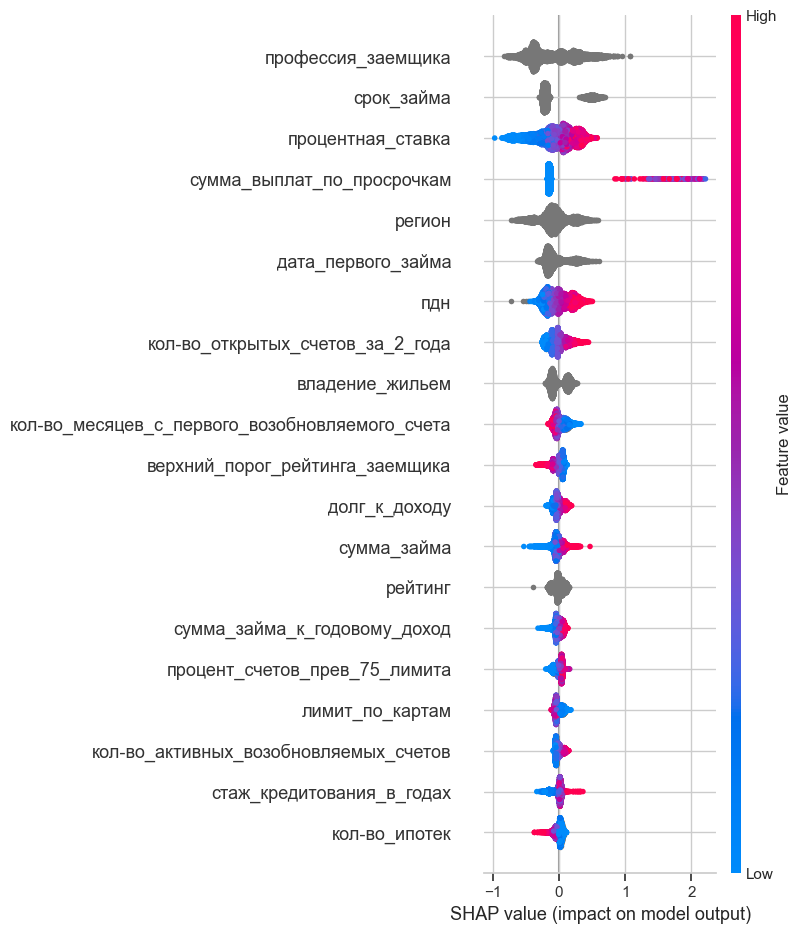

In [74]:
# Будем интерпритировать на случайном выборе людей, чтобы не перегружать систему
X = add_new_featers(train).drop('итоговый_статус_займа', axis=1).copy(deep=True) # Вновь определим набор данных, на которых считать значимость признаков
cat_features = list(X.select_dtypes(include=['object']).columns)
for col in cat_features:
    X[col] = X[col].fillna('missing') 

X_sample = X.sample(n=10000, random_state=42)

# Создаём explainer
explainer = shap.TreeExplainer(final_model)

# Считаем shap_values на подвыборке
shap_values = explainer.shap_values(X_sample)

# Строим график
shap.summary_plot(shap_values, X_sample)


Можно утверждать, что с увеличением значения увеличивают вероятность дефолта признаки: суммы выплат по просрочкам, пдн, долг к доходу, сумма займа к годову доходу, сумма займа, стаж кредитования в годах. Обратная зависимость может наблюдаться для количество месяцев с первого возобновляемого счета, верхнего порога заемщика, лимита по картам и кол-ва ипотек.

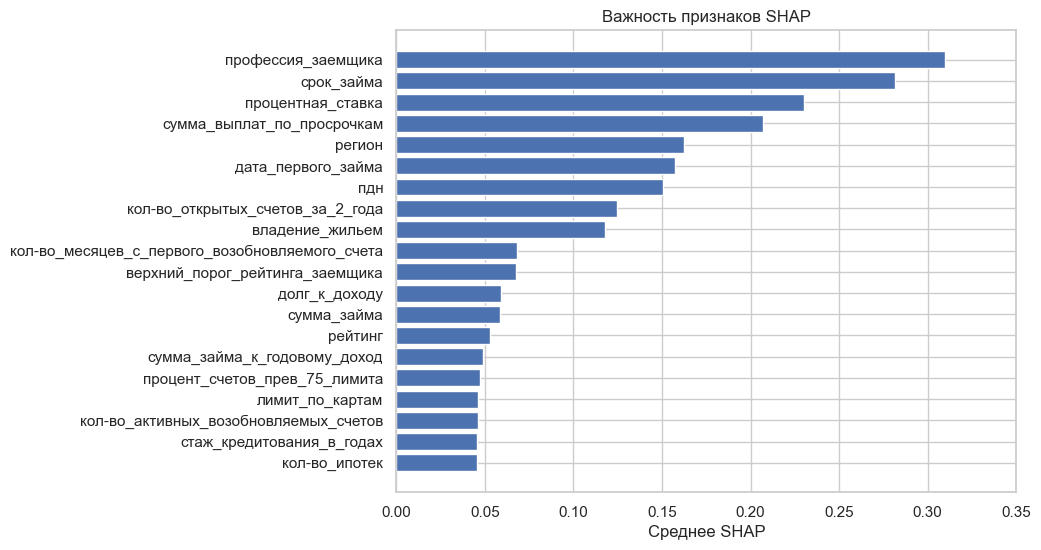

In [77]:
shap_class1 = shap_values[1]
importance = np.mean(np.abs(shap_values), axis=0)
imp_df = pd.DataFrame({'feature': X_sample.columns, 'importance': importance})
imp_df = imp_df.sort_values('importance', ascending=False)


top_n = 20
plt.figure(figsize=(8, 6))
plt.barh(imp_df['feature'][:top_n][::-1], imp_df['importance'][:top_n][::-1])
plt.xlabel('Среднее SHAP')
plt.title('Важность признаков SHAP')
plt.xlim(0, 0.35)
plt.show()

Видим, что наибольшой вклад в решение дают признаки срок займа, профессия, регион, пдн, рейтинг. Признаки рейтинг и допрейтиг каким-то образом считается в системе банка на основе других признаков. Было бы интересно попробовать воспользоваться ML, чтобы понять на основе каких признаков считается этот допрейтинг. Для этого следовало бы исключить из базы данных колонки рейтинг и итоговый_статус_займа. После чего попробовать с помощью модели бустинга обучиться предсказывать подрейтинг на  основе других колонок и посмотреть какие из них дают наибольший вклад. Однако это требует отдельного исследования.

### 10.2. Значимость признаков для отдельных клиентов

Попробуем интерпритировать решение модели на конкретных клиентах, а именно посмотрим на основании каких причин она принимает решение. Это позволит проще интерпретировать результаты в реальность.

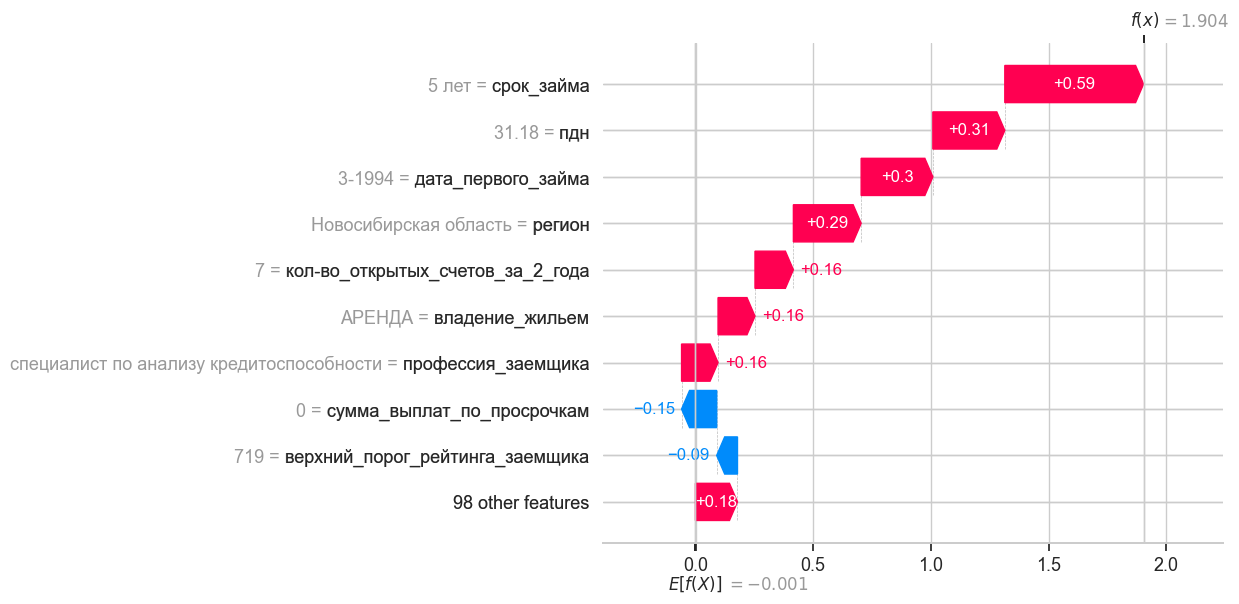

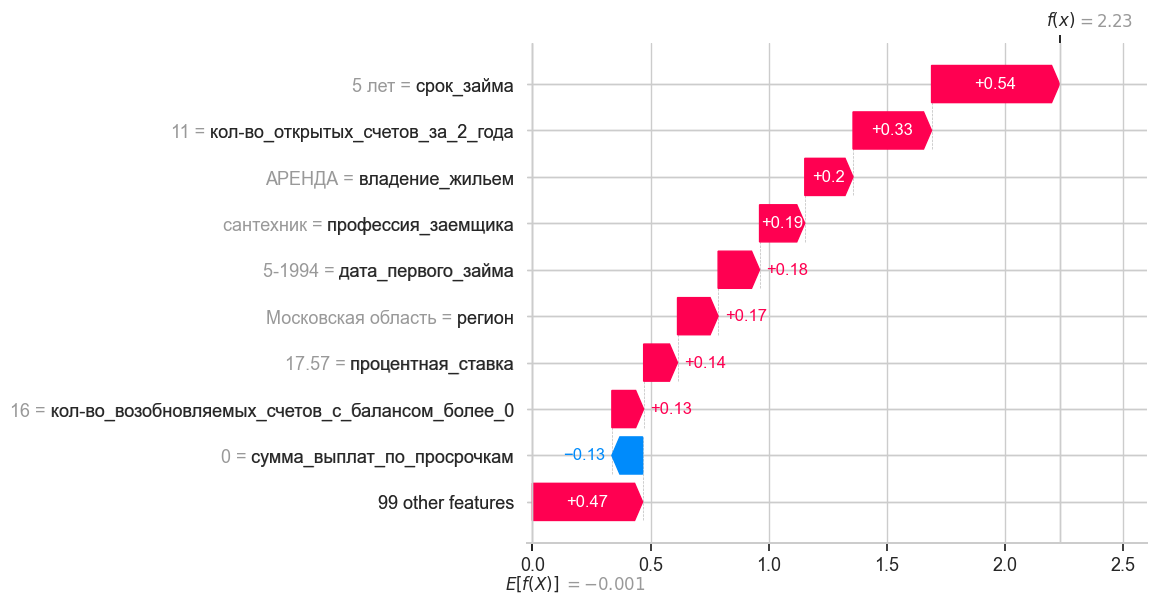

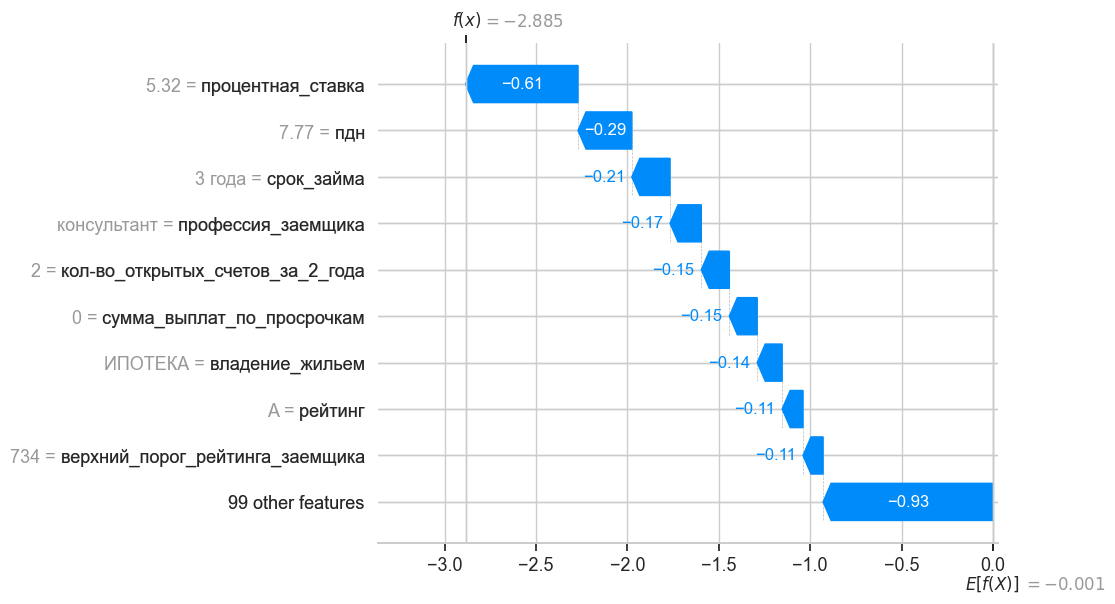

In [78]:
# Построим график для рандомного клиента, клиента из группы риска и надежного клиента
np.random.seed(101)
client_data = X.iloc[[np.random.randint(0, len(X))]]
shap_values = explainer.shap_values(client_data)
shap.waterfall_plot(
    shap.Explanation(values=shap_values[0], 
                     base_values=explainer.expected_value, 
                     data=client_data.iloc[0])
)
# Создадим группы риска
probs = final_model.predict_proba(X)[:, 1]
df_res = X.copy()
df_res['prob_default'] = probs


high_risk = df_res[df_res['prob_default'] >= 0.9]
high_risk_client_data = high_risk.iloc[[np.random.randint(0, len(high_risk))]]
high_risk_shap_values = explainer.shap_values(high_risk_client_data)
shap.waterfall_plot(
    shap.Explanation(values=high_risk_shap_values[0], 
                     base_values=explainer.expected_value, 
                     data=high_risk_client_data.iloc[0])
)


low_risk  = df_res[df_res['prob_default'] <= 0.1] 
low_risk_client_data = low_risk.iloc[[np.random.randint(0, len(low_risk))]]
low_risk_shap_values = explainer.shap_values(low_risk_client_data)
shap.waterfall_plot(
    shap.Explanation(values=low_risk_shap_values[0], 
                     base_values=explainer.expected_value, 
                     data=low_risk_client_data.iloc[0])
)

Для первого клиента (рандомный выбор), можно указать, что основным фактором влияющим на отказ в кредите будет являться срок займа (если так просит клиент), пдн, регион и дата первого займа, это все признаки которые увличивают риск невозврата денег.  
Для второго клиента (из группы риска), ключевыми факторами отказа будут являться срок займа, кол-во открытых счетов за последние 2 года, тип владения жильем и его профессия.  
Для третьего клиента (с большой вероятностью вернет займ), основными признаками на котоыре модель опирается, является процентная ставка и пдн, а также срок займа и профессия, а также основной вклад дает 99других признаков в совокупности.

## 11. Проверка утечки данных через признаки

Также следует проверить гипотезу об утечки данных через колонку пени_за_дефолт. Если посчитать roc-auc-score для базы данных содержащей колонку пени_за_дефолт для финальной модели Catboost, то метрика окажется достаточно впечатляющей - 0.88, что делает эту колонку еще более скомпроментированной. Следует проверить нет ли таких же аномалий при удалении других значимых колонок, однако они не вызывают подозрения с точки зрения логики. Можно попробовать обучить модель без тех колонок, о которых я упоминал в начале исследования данных как о признаках потенциально имеющих утечку (сумма_выплат_по_просрочкам, пени_за_дефолт, общая_сумма_взысканий, кол-во_месяцев_с_последнего_нарушения).

In [79]:
X = train.copy()
for col in ['сумма_выплат_по_просрочкам', 'пени_за_дефолт', 'общая_сумма_взысканий', 'кол-во_месяцев_с_последнего_нарушения']:
    if col in train.columns:
        X = X.drop(col, axis=1)

X = X.drop('итоговый_статус_займа', axis=1)
y = train['итоговый_статус_займа']

cat_cols = X.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    X[col] = X[col].fillna('missing')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, stratify=y)

cat_boost = CatBoostClassifier(**final_params)
cat_boost.fit(Pool(X_train, y_train, cat_features=cat_cols))

roc_auc_clean = roc_auc_score(y_test, cat_boost.predict_proba(X_test)[:, 1])
roc_auc_clean


Default metric period is 5 because AUC is/are not implemented for GPU


0.7492145074030154

roc_auc_clean - не сильно отличается от полученного на базе данных содержащих подозрительные колонки. Это служит косвенным, но не полным доказательством отсутствия утечки, ведь в таблице могут присутствовать колонки зависящие от удаленных. Для более строго доказательства надо проделать дополнительные исследования влияния отдельных колонок на roc-auc-score.

## 12. Предсказания и сохранение submission

Наконец предскажем вероятность возврата займа для тестового набора с помощью модели CatBoostClassifier Обученной на всей выборке. Для этого сначала приведем тестовые данные в подходящий вид, после чего передадим их в финальную модель

In [80]:
# Подготовим тестовые данные, по аналогии с тренировочными
X_test = test.drop(['коэфф_невыплаченного_сумм_остатка', 
                    'непогашенная_сумма_из_тела_займов', 
                    'код_политики', 'дата_следующей_выплаты', 
                    'кредитный_баланс_по_возоб_счетам', 'пени_за_дефолт', 'id'], axis=1).copy()

X_test['пдн'] = X_test['пдн'].replace([-1, 999], np.nan)
X_test['кол-во_месяцев_с_последнего_займа'] = X_test['кол-во_месяцев_с_последнего_займа'].replace(999, np.nan)

# Переводим в категориальные переменные
X_test['рейтинг_OCR'] = X_test['рейтинг_OCR'].astype(str)

X_test = add_new_featers(X_test)

cat_cols= list(X_test.select_dtypes(include=['object']).columns)
for col in cat_cols:
    X_test[col] = X_test[col].fillna('missing') 

In [ ]:
test_predict = final_model.predict_proba(X_test)[:, 1]

# Формируем сабмит
answer = pd.DataFrame()
answer['id'] = test['id']
answer['proba'] = test_predict
answer.to_csv('submission.csv', index=False)

Посчитаем предсказание модели LightGBMClassifier с оптимальными параметрами на тестовых данных. Для этого проведем с ними все операции необходимые для преобразования в формат подходящий для модели по аналогии с тренировочными данными.

## Итог
В ходе решения задачи кредитного скоринга реализован полный и воспроизводимый пайплайн, включающий: исследовательский анализ данных (EDA), обработку пропусков, фичеинжиниринг, отбор и сравнение моделей, подбор гиперпараметров и интерпретацию результатов.

По итогам экспериментов с несколькими алгоритмами (логистическая регрессия, случайный лес, LightGBM, XGBoost) финальный выбор сделан в пользу CatBoost — модели, которая показала наилучший баланс качества и устойчивости на кросс-валидации, а также эффективно обрабатывает категориальные признаки без сложного кодирования.

В рамках работы:

* Проведён системный подбор гиперпараметров с использованием стратифицированной кросс-валидации.

* Выполнена проверка признаков на утечки информации и оценка их вклада с помощью SHAP.

* Получены как глобальные, так и локальные интерпретации модели, что обеспечивает прозрачность принимаемых решений.

* Модель стабилизирована через фиксацию случайных сидов и единообразный препроцессинг для train/test.

Финальная модель демонстрирует высокое качество по метрике ROC-AUC на валидации, готова к применению на тестовом наборе и отвечает требованиям задачи: ноутбук воспроизводим, код оптимизирован и прокомментирован, итоговый файл submisson.csv сформирован в заданном формате, подготовлен requirements.txt.